# prep

In [32]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_data(dir_path):
    file_path = dir_path.replace('\\', '/')
    data = sio.loadmat(file_path + '/trace_trial_stim.mat')
    
    stim_seq = data['stim_seq']
    stim_id = [i[0] for i in stim_seq]
    trace_by_trial = data['trace_by_trial']

    ncell = trace_by_trial.shape[0]
    nstim = len(np.unique(stim_id))
    ntrial = trace_by_trial.shape[1]
    nframe = trace_by_trial.shape[2]
    print(ncell, nstim, ntrial, nframe)

    return stim_id, trace_by_trial, # ncell, nstim, ntrial, nframe


def calc_trace_stim(trace_by_trial, stim_id):
    trace_avg_cell = np.mean(np.mean(trace_by_trial, axis=0), axis=0)
    trace_stim_avg = []
    # trace_stim_std = []
    # trace_stim_sem = []

    for i in np.unique(stim_id):
        trace_istim_avg = np.mean(trace_by_trial[:, np.where(stim_id == i)[0]], axis=1) # ncell x nframe
        trace_istim_avg = np.mean(trace_istim_avg, axis=0) # nframe
        # trace_istim_std = np.std(trace_by_trial[:, np.where(stim_id == i)[0]], axis=1)
        # trace_istim_sem = trace_istim_std / np.sqrt(len(np.where(stim_id == i)[0]))

        trace_stim_avg.append(trace_istim_avg)
        # trace_stim_std.append(trace_istim_std)
        # trace_stim_sem.append(trace_istim_sem)

    print(len(trace_stim_avg), trace_stim_avg[0].shape)
    return trace_avg_cell, trace_stim_avg

# compare trace

In [4]:
# i1369 V1 high res, cellpose
dir_path = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1369_220310_cellpose'
stim_id_cellpose, trace_by_trial_cellpose = load_data(dir_path)
trace_avg_cell_cellpose, trace_stim_avg_cellpose = calc_trace_stim(trace_by_trial_cellpose, stim_id_cellpose)

# i1369 V1 high res, manual
dir_path = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1369_220310'
stim_id_manual, trace_by_trial_manual = load_data(dir_path)
trace_avg_cell_manual, trace_stim_avg_manual = calc_trace_stim(trace_by_trial_manual, stim_id_manual)

114 30 511 156
30 (156,)
155 30 511 156
30 (156,)


In [26]:
# normalize trace to same max min
trace_avg_cell_cellpose_norm = (trace_avg_cell_cellpose - np.min(trace_avg_cell_cellpose)) / (np.max(trace_avg_cell_cellpose) - np.min(trace_avg_cell_cellpose))
trace_avg_cell_manual_norm = (trace_avg_cell_manual - np.min(trace_avg_cell_manual)) / (np.max(trace_avg_cell_manual) - np.min(trace_avg_cell_manual))

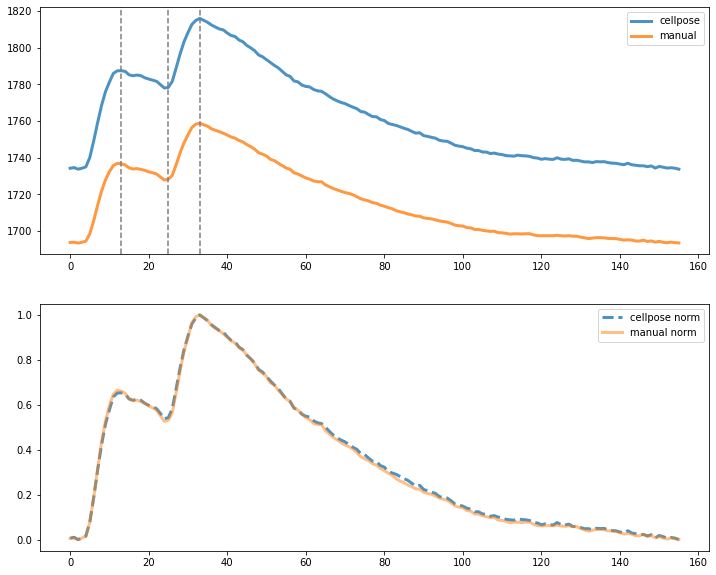

In [31]:
# try no normalization
plt.figure(figsize=(12, 10))

plt.subplot(2,1,1)
plt.plot(trace_avg_cell_cellpose, alpha=0.8, linewidth=3) # - 50
plt.plot(trace_avg_cell_manual, alpha=0.8, linewidth=3)

plt.axvline(x=np.argmax(trace_avg_cell_cellpose[:25]), color='gray', linestyle='--')
plt.axvline(x=np.argmin(trace_avg_cell_cellpose[25:30]) + 25, color='gray', linestyle='--')
plt.axvline(x=np.argmax(trace_avg_cell_cellpose), color='gray', linestyle='--')
plt.legend(['cellpose', 'manual'])

plt.subplot(2,1,2)
plt.plot(trace_avg_cell_cellpose_norm, alpha=0.8, linewidth=3, linestyle='--')
plt.plot(trace_avg_cell_manual_norm, alpha=0.5, linewidth=3)
plt.legend(['cellpose norm', 'manual norm'])

# compare adp

In [53]:
d = {'mouse': [1369, 1369], 'date': ['220310', '220310_cellpose'], 'area': ['V1', 'V1']}
meta = pd.DataFrame(data=d)
print(meta)

   mouse             date area
0   1369           220310   V1
1   1369  220310_cellpose   V1


In [70]:
nset = len(meta.index); ncell = []; nori = 30; nframe_trial = 156
dir_name = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter'.replace('\\', '/')

def load_dfof(iset):
    dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])

    dfof = sio.loadmat(os.path.join(dir_name, dir_sub, 'dfof' + '.mat'))
    dfof_ad = dfof['dfof_ad']
    dfof_tg = dfof['dfof_tg']
    ncell = dfof['dfof_ad'].shape[0]

    return dfof_ad, dfof_tg, ncell

def threshold_dfof(dfof_ad, dfof_tg, thres=0):
    # thres = np.percentile(dfof_ad, 5)
    dfof_ad_thres = dfof_ad[dfof_ad > thres]
    dfof_tg_thres = dfof_tg[dfof_ad > thres] # threshold by resp to adapter
    return dfof_ad_thres, dfof_tg_thres

def calc_adp(dfof_ad, dfof_tg):
    adp = (dfof_tg - dfof_ad) / (dfof_ad + 1e-7)
    return adp

In [72]:
dfof_ad_cellpose, dfof_tg_cellpose, ncell_cellpose = load_dfof(0)
dfof_ad_thres_cellpose, dfof_tg_thres_cellpose = threshold_dfof(dfof_ad_cellpose, dfof_tg_cellpose, 0) # cellpose did not filter by vis-driven, set thres of resp_ad to 0 for now
adp_cellpose = calc_adp(dfof_ad_thres_cellpose, dfof_tg_thres_cellpose)

dfof_ad_manual, dfof_tg_manual, ncell_manual = load_dfof(1)
dfof_ad_thres_manual, dfof_tg_thres_manual = threshold_dfof(dfof_ad_manual, dfof_tg_manual, 0)
adp_manual = calc_adp(dfof_ad_thres_manual, dfof_tg_thres_manual)

In [73]:
adp_manual.shape, adp_manual.flatten().shape

((2509,), (2509,))

In [74]:
np.median(adp_manual.flatten()), np.median(adp_cellpose.flatten()), np.mean(adp_manual.flatten()), np.mean(adp_cellpose.flatten())

(-0.49900762814673866,
 -0.5203660336111142,
 -0.26659226273896414,
 -1.1929833838530304)

In [ ]:
ax = sns.boxplot(x="total_bill", y="day", data=tips, whis=np.inf)
ax = sns.swarmplot(x="total_bill", y="day", data=tips, color=".2")

In [46]:
# # dfof_ad = np.empty([0, nori]); dfof_tg = np.empty([0, nori])
# # dfof_ad_std = np.empty([0, nori]); dfof_tg_std = np.empty([0, nori])
# # trace = np.empty([0, nori, nframe_trial])

# for iset in np.arange(nset):
#     dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])

#     dfof = sio.loadmat(os.path.join(dir_name, dir_sub, 'dfof' + '.mat'))
#     dfof_ad = np.concatenate((dfof_ad, dfof['dfof_ad']), axis=0)
#     dfof_ad_std = np.concatenate((dfof_ad_std, dfof['dfof_ad_std']), axis=0)
#     dfof_tg = np.concatenate((dfof_tg, dfof['dfof_tg']), axis=0)
#     dfof_tg_std = np.concatenate((dfof_tg_std, dfof['dfof_tg_std']), axis=0)
    
#     # trace_align = sio.loadmat(os.path.join(dir_name, dir_sub, 'trace_aligned' + '.mat'))
#     # trace_flat = np.empty([ncell[iset], nori, nisi, nframe_trial]);
#     # for icell in np.arange(ncell[iset]):
#     #     for iori in np.arange(nori):
#     #         for iisi in np.arange(nisi):
#     #             trace_flat[icell][iori][iisi][:] = trace_align['trace_avg'][icell][iori][iisi].flatten()
#     # trace = np.vstack((trace,trace_flat))

#     ncell.append(dfof['dfof_ad'].shape[0])

   mouse             date area
0   1369           220310   V1
1   1369  220310_cellpose   V1
